#W207 Machine Learning Final Project #
###Forest Cover Type Prediction###
Amitava Das & Katherine Shelley

###Data Dictionary###

####Part 1: Data Collection and Baseline Estimation####
First we will download the data and split it into a training, development, and test sets.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for cleaning/feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_classif

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

#metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
np.random.seed(0)

In [3]:
#read the training data into a pandas dataframe
data = os.path.join(os.getcwd(),'train.csv')
df_train = pd.read_csv(data)

#read the test data into a pandas frame
data = os.path.join(os.getcwd(),'test.csv')
df_test = pd.read_csv(data)

#THIS DOES NOT WORK RIGHT, I'M STILL WORKING ON IT :)
#let's add some new variables that represent the climatic and geologic zones (first two digits of the soil type variable)
#we'll use a dicitonary to isolate the soil id's by their climatic/geologic prefix
soil_id = {'27':['1','2','3','4','5','6'],
           '35':['7','8'],
           '42':['9'],
           '47':['10','11','12','13'],
           '51':['14','15'],
           '61':['16','17'],
           '67':['18'],
           '71':['19','20','21'],
           '72':['22','23'],
           '77':['24','25','26','27','28','29','30','31','32','33','34'],
           '87':['35','36','37','38','39','40']
          }

climatic = {'2':['1','2','3','4','5','6'],
            '3':['7','8'],
           '4':['9','10','11','12','13'],
           '5':['14','15'],
           '6':['16','17','18'],
           '7':['19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34'],
           '8':['35','36','37','38','39','40']
           }

geologic = {'1':['14','15','16','17','19','20','21'],
            '2':['9','22','23'],
            '5':['7','8'],
            '7':['1','2','3','4','5','6','10','11','12','13','18','24','25','26','27','28',
                 '29','30','31','32','33','34','35','36','37','38','39','40']
           }

''' 
#add new variables for the soil type prefix, climatic zone, and geologic zone
for key in soil_id:
    clim,geol = key[0],key[1]
    df_train['soil prefix %s' % key] = np.zeros(len(df_train.index))
    np.sum(np.asarray(df_train[['Soil_Type%s' % i for i in soil_id[key]]]),axis=1)
    df_train['climatic zone %s' % clim] = np.sum(np.asarray(df_train[['Soil_Type%s' % i for i in climatic[clim]]]),axis=1)
    df_train['geologic zone %s' % geol] = np.sum(np.asarray(df_train[['Soil_Type%s' % i for i in geologic[geol]]]),axis=1)
'''

#print df_train.head(20)
#Initialize a standard scaler for non-binary variables
scaler = StandardScaler() #we'll start by scaling all the float variables
#variables to scale
scale = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
       'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']

#Separate the features from the labels, remove the ID column, convert to numpy arrays 
X_scaled = scaler.fit_transform(df_train[scale].as_matrix())
X = df_train.drop(scale,1).drop(['Id','Cover_Type'],1).as_matrix()
X = np.concatenate([X_scaled,X],axis=1)
Y = df_train['Cover_Type'].as_matrix()
del X_scaled
del df_train

#Separate the test data ID column, scale the real-valued features
test_ids = df_test['Id']
test_scaled = scaler.transform(df_test[scale].as_matrix())
test_data = df_test.drop(scale,1).drop('Id',1).as_matrix()
test_data = np.concatenate([test_scaled,test_data],axis=1)
del test_scaled
del df_test


# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))

X, Y = X[shuffle], Y[shuffle]
print 'Training data shape: ', X.shape
print 'Tranining label shape: ', Y.shape
#print 'Test data shape: ', test_data.shape



Training data shape:  (15120, 54)
Tranining label shape:  (15120,)


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [4]:
def InitialBaseline():
    # Instantiate the KNeighborsClassifier class with appropriate k for entire data set
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X,Y)
    predicted = clf.predict(test_data)
    outfile = zip(test_ids, predicted)
    np.savetxt("BaseSubmission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id, Cover_Type',comments='')
    print "Saved ", len(outfile),"records to BaseSubmission.csv"
    
InitialBaseline()

Saved  565892 records to BaseSubmission.csv


###Improving the model###
Now that we have a baseline prediciton score, let's see what we can do to improve it. First we will separate our training data into training, development, and test sets. We will not use the test set until we have finalized our model. Tuning will be performed with the development set only to avoid overfitting to the test set.

In [4]:
# Set some variables to hold dev and training data;
N = X.shape[0]
#test_data, test_labels = X[2*N/3:], Y[2*N/3:]
dev_data, dev_labels = X[N/2:], Y[N/2:]
train_data, train_labels = X[:N/2], Y[:N/2]

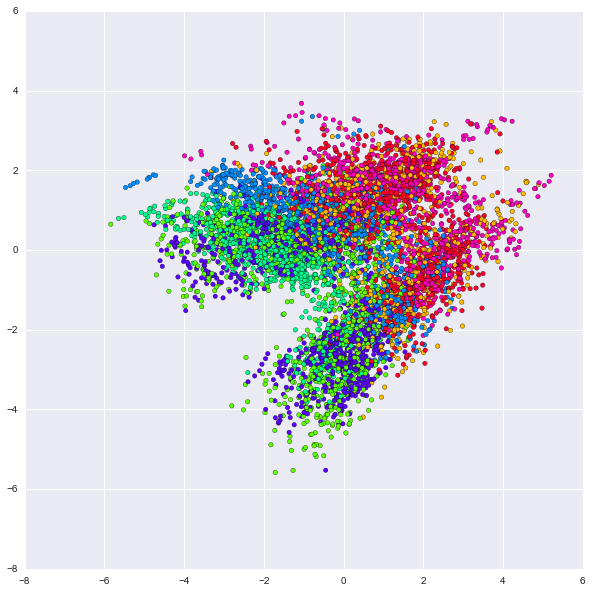

In [5]:
#Let's do some exploratory analysis. We'll project the scaled data onto two dimensions so we can plot the points
#and color by label to see if we can see a relationship.
pca = PCA(n_components=2)
reduced = pca.fit_transform(train_data)

colorlist = plt.cm.gist_rainbow(np.linspace(0,1,7)) #get a list of 7 colors
pltcolors = [colorlist[i-1] for i in train_labels]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.scatter(reduced.T[0],reduced.T[1],c=pltcolors)


The 2 dimensional plot is not very telling. This is not too surprising, though, because of all the binary categorical variables such as soil type.

###Dimensionality Reduction###

Before we start to tune our model, let's try to reduce the dimensionality of our data set. We will use the method of 'Retained Variance' to reduce the dimensionality of our data, i.e. we will reduce the dimensionality only up to the point where we retain 99% of the variance.

In [6]:
#let's run PCA on the data but not set any component value so we can determine how many principal components we should keep 
#to capture as much of the variance as possible.
pca = PCA()
reduced = pca.fit(train_data)

var = 0 #retained variance
k = 0 #number of components
while var < 0.99:
    k+=1
    var = np.cumsum(pca.explained_variance_ratio_,axis=0)[k]
print "Optimal number of principal components is %s" % k

Optimal number of principal components is 28


###K-Means Clustering###

In [7]:
#Now that we have an optimal value for PCA, let's try a k-means clustering algorithm
def kmeans_test(train_data,train_labels,test_data,test_labels,components,clusters):
    pca = PCA(n_components=components)
    reduced = pca.fit_transform(train_data)
    kmeans = KMeans(n_clusters=clusters)
    prediction = kmeans.fit_predict(reduced)
    
    reduced_test = pca.transform(test_data)
    accuracy = np.mean(kmeans.predict(reduced_test)==test_labels)
    return accuracy
print kmeans_test(train_data,train_labels,dev_data,dev_labels,29,7)

0.0616402116402


###Logistic Regression###
Let's test a few models besides K Nearest Neighbors. Starting with Logistic Regression.

In [8]:
lm = LogisticRegression() #initialize a logistic regression model
parameters = {'C':[10**i for i in range(-5,5)]}
clf = GridSearchCV(lm, parameters)
clf.fit(train_data,train_labels)
print '%s Accuracy using C = %s' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['C'])

67.791005291 Accuracy using C = 100


###Naive Bayes###
Now let's test a Naive Bayes model. We'll first test a Mulinomial Naive Bayes classifier, and then a Gaussian Naive Bayes model.

In [9]:
parameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
clf = GridSearchCV(BernoulliNB(binarize = 0.5),parameters)
clf.fit(train_data,train_labels)
print 'Bernoulli Naive Bayes gives %s percent Accuracy using alpha = %s' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['alpha'])

''' Multinomial NB is giving me errors
clf = GridSearchCV(MultinomialNB(),parameters)
clf.fit(train_data,train_labels)
print 'Bernoulli Naive Bayes gives %s percent Accuracy using alpha = %s' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['alpha'])
'''

Bernoulli Naive Bayes gives 62.4206349206 percent Accuracy using alpha = 0.0001


" Multinomial NB is giving me errors\nclf = GridSearchCV(MultinomialNB(),parameters)\nclf.fit(train_data,train_labels)\nprint 'Bernoulli Naive Bayes gives %s percent Accuracy using alpha = %s' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['alpha'])\n"

###Support Vector Machines###
Now let's test Support Vector Machines. Note, this cell takes several minutes to run.

In [10]:
parameters = {'C':[10**i for i in range(-2,2)],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(train_data,train_labels)
print 'SVM gives %s percent Accuracy using C = %s and a %s kernel' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['C'],clf.best_params_['kernel'])


SVM gives 76.2433862434 percent Accuracy using C = 10 and a rbf kernel


###Random Forests###
Now Let's test Random Forests for various values of n trees. Note, this cell takes several minutes to run.

In [ ]:
parameters = {'n_estimators':[10**i for i in range(4)]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(train_data,train_labels)
print 'Random Forest gives %s percent Accuracy using n = %s trees' % (clf.score(dev_data,dev_labels)*100,clf.best_params_['n_estimators'])


In [14]:
def RunRF():
    # Instantiate the Random Forests class with appropriate n (1000 from above), using the entire set to train
    clf =RandomForestClassifier(n_estimators=1000)
    clf.fit(X,Y)
    predicted = clf.predict(test_data)
    outfile = zip(test_ids, predicted)
    np.savetxt("RFSubmission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id, Cover_Type',comments='')
    print "Saved ", len(outfile),"records to RFSubmission.csv"
    
RunRF()

Saved  565892 records to RFSubmission.csv


###K Nearest Neighbors###
Now Let's test K Nearest Neighbors for various values of k.

In [9]:
parameters = {'n_neighbors' :[i for i in range(1,101)]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(train_data,train_labels)
print clf.score(dev_data,dev_labels)


0.779497354497


###Feature Tuning - Random stuff, don't worry about this cell###
Now let's tune some of these features.

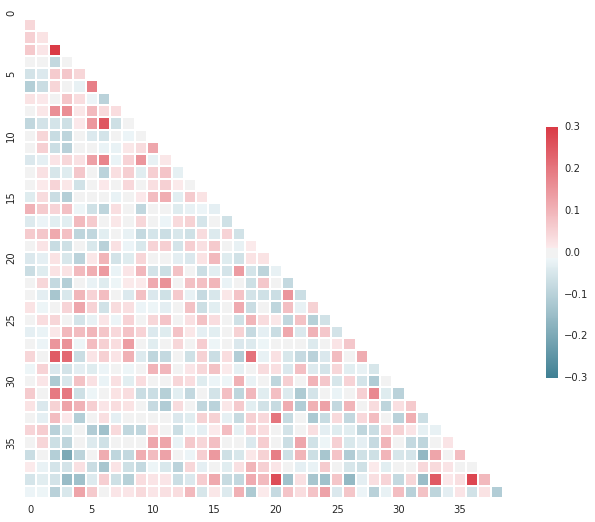

In [20]:
corr = np.cov(X[-40:]) #create a covariance matrix for the soil type binary variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)